# Training on MNIST Dataset using Pytorch Operator

Using PyTorch to build a model with two convolutional layers and two fully connected layers to perform the multi-class classification of images provided.


### Requirement
All you need is this notebook running in Kubeflow Notebook Server once you have cloned this repo
You can use the pre-packaged Docker image here but if  you choose to build your own docker image, you must also have a Docker client installed on your machine.

## Prerequisites
Before we proceed, check to see if Pytorch is already installed in your Notebook Server Environment or not

In [1]:
! pip list | grep torch
! pip3 install ipywidgets 
! pip3 install torch torchvision matplotlib --no-cache-dir

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


To get started package the trainer in a Docker container image

In [2]:
TRAINER_FILE = "mnist.py"
KUBERNETES_FILE = "pytorchjob-mnist.yaml"

We also want to capture output from a cell with [`%%capture`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture) that usually looks like `some-resource created`.
To that end, let's define a helper function:

In [3]:
import re

from IPython.utils.capture import CapturedIO


def get_resource(captured_io: CapturedIO) -> str:
    """
    Gets a resource name from `kubectl apply -f <configuration.yaml>`.

    :param str captured_io: Output captured by using `%%capture` cell magic
    :return: Name of the Kubernetes resource
    :rtype: str
    :raises Exception: if the resource could not be created
    """
    out = captured_io.stdout
    matches = re.search(r"^(.+)\s+created", out)
    if matches is not None:
        return matches.group(1)
    else:
        raise Exception(
            f"Cannot get resource as its creation failed: {out}. It may already exist."
        )

## Download the Data

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-17 07:43:43--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-17 07:43:43--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [              <=>   ]  33.20M  12.1MB/s    in 2.7s    

2021-03-17 07:43:46 (12.1 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

## How to Load and Inspect the Data
Initialize Torch with the downloaded dataset.

In [5]:
import torchvision
import torchvision.transforms as transforms
root_dir = './'
torchvision.datasets.MNIST(root=root_dir,download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

In [6]:
from torchvision import datasets, transforms

# See: https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST
mnist = datasets.MNIST("./", download=True, train=True, transform=transforms.ToTensor())
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
list(mnist.data.size())

[60000, 28, 28]

We are therefore dealing with 60,000 28x28 pixel greyscale images.
These have not yet been scaled into the [0, 1] range, as we can see:

In [8]:
mnist.data.float().min(), mnist.data.float().max()

(tensor(0.), tensor(255.))

In [9]:
# See: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
example, example_label = mnist.__getitem__(42)

In [10]:
import numpy as np
from matplotlib import pyplot as plt

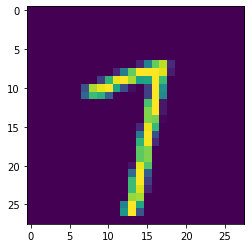

In [12]:
%matplotlib inline
plt.imshow(np.squeeze(example))
plt.show()

The corresponding label is:

In [13]:
example_label

7

We shall normalize the data set (to improve the training speed), which means we need to know the mean and standard deviation:

In [14]:
mnist.data.float().mean() / 255, mnist.data.float().std() / 255

(tensor(0.1307), tensor(0.3081))

These are the values we will hard-code in our transformations within the model.
Ideally, we re-compute these based on the training data set to ensure we capture the correct values when the underlying data changes.
Our data set is static, though.

In [15]:
# Clear variables as we have no need for these any longer
del mnist, example, example_label

In [16]:
epochs = 5

## How to Train the Model in the Notebook

Since we ultimately want to train the model in a distributed mode, we put all the code in a single cell.
That way we can save the file and include it in a container image:

In [17]:
%%writefile $TRAINER_FILE
import argparse
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

logging.getLogger().setLevel(logging.INFO)

# Number of processes participating in (distributed) job
# See: https://pytorch.org/docs/stable/distributed.html
WORLD_SIZE = int(os.environ.get("WORLD_SIZE", 1))


# Custom models must subclass toch.nn.Module and override `forward`
# See: https://pytorch.org/docs/stable/nn.html#torch.nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1


def is_distributed():
    return dist.is_available() and dist.is_initialized()


def percentage(value):
    return "{: 5.1f}%".format(100.0 * value)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            logging.info(
                f"Epoch: {epoch} ({percentage(batch_idx / len(train_loader))}) - Loss: {loss.item()}"
            )


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum batch losses
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    logging.info(
        f"Test accuracy: {correct}/{len(test_loader.dataset)} ({percentage(correct / len(test_loader.dataset))})"
    )

    # Log metrics for Katib
    logging.info("loss={:.4f}".format(test_loss))
    logging.info("accuracy={:.4f}".format(float(correct) / len(test_loader.dataset)))


def main():
    parser = argparse.ArgumentParser(description="PyTorch MNIST Training Job")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="Batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="Batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=5,
        metavar="N",
        help="Number of epochs to train",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=1.0,
        metavar="LR",
        help="Learning rate (default: 1.0)",
    )
    parser.add_argument(
        "--gamma",
        type=float,
        default=0.7,
        metavar="M",
        help="Learning rate's decay rate (default: 0.7)",
    )
    parser.add_argument(
        "--no-cuda",
        action="store_true",
        default=False,
        help="Disables CUDA (GPU) training",
    )
    parser.add_argument(
        "--seed", type=int, default=1, metavar="S", help="Random seed (default: 1)"
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="Number of training batches between status log entries",
    )
    parser.add_argument(
        "--save-model",
        action="store_true",
        default=False,
        help="Whether to save the trained model",
    )

    if dist.is_available():
        parser.add_argument(
            "--backend",
            type=str,
            help="Distributed backend",
            choices=[dist.Backend.GLOO, dist.Backend.NCCL, dist.Backend.MPI],
            default=dist.Backend.GLOO,
        )

    args, _ = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    if should_distribute():
        logging.debug("Using distributed PyTorch with {} backend".format(args.backend))
        dist.init_process_group(backend=args.backend)

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    train_data = datasets.MNIST(
        "./",
        download=False,
        train=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    )

    # DistributedSampler partitions the training dataset among the worker processes
    train_sampler = (
        torch.utils.data.distributed.DistributedSampler(train_data)
        if should_distribute()
        else None
    )

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=args.batch_size,
        sampler=train_sampler,
        shuffle=False,
        **kwargs,
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "./",
            download=False,
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        ),
        batch_size=args.test_batch_size,
        shuffle=True,
        **kwargs,
    )

    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().to(device)

    if is_distributed():
        if use_cuda:
            torch.cuda.set_device(torch.cuda.current_device())
        model = nn.parallel.DistributedDataParallel(model)

    # See: https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    # See: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_model.pt")


if __name__ == "__main__":
    main()

Overwriting mnist.py


Let's see if our code is correct by running it from within our notebook:

In [18]:
%run $TRAINER_FILE --epochs $epochs --log-interval 128

INFO:root:Epoch: 1 (  0.0%) - Loss: 2.29303240776062
INFO:root:Epoch: 1 ( 13.6%) - Loss: 0.5207589864730835
INFO:root:Epoch: 1 ( 27.3%) - Loss: 0.07054267078638077
INFO:root:Epoch: 1 ( 40.9%) - Loss: 0.19108931720256805
INFO:root:Epoch: 1 ( 54.6%) - Loss: 0.37162208557128906
INFO:root:Epoch: 1 ( 68.2%) - Loss: 0.08093594014644623
INFO:root:Epoch: 1 ( 81.9%) - Loss: 0.3664531111717224
INFO:root:Epoch: 1 ( 95.5%) - Loss: 0.03546219691634178
INFO:root:Test accuracy: 9838/10000 ( 98.4%)
INFO:root:loss=0.0486
INFO:root:accuracy=0.9838
INFO:root:Epoch: 2 (  0.0%) - Loss: 0.08004315942525864
INFO:root:Epoch: 2 ( 13.6%) - Loss: 0.25475379824638367
INFO:root:Epoch: 2 ( 27.3%) - Loss: 0.009925932623445988
INFO:root:Epoch: 2 ( 40.9%) - Loss: 0.09941373765468597
INFO:root:Epoch: 2 ( 54.6%) - Loss: 0.20104627311229706
INFO:root:Epoch: 2 ( 68.2%) - Loss: 0.06250841170549393
INFO:root:Epoch: 2 ( 81.9%) - Loss: 0.10338491201400757
INFO:root:Epoch: 2 ( 95.5%) - Loss: 0.009137551300227642
INFO:root:Test

<Figure size 432x288 with 0 Axes>

The Dockerfile looks as follows:

```
FROM mavencodev/pytorch_job:1.0
ADD mnist.py /
ADD datasets /datasets

ENTRYPOINT ["python", "/mnist.py"]
```

Then it's easy to push images to your container registry:

```bash
docker build -t <docker_image_name_with_tag> .
docker push <docker_image_name_with_tag>
```

The image is available as `mavencodev/pytorch_job:1.0` in case you want to skip it for now.

## How to Create a Distributed `PyTorchJob`
For large training jobs, we wish to run our trainer in a distributed mode.
Once the notebook server cluster can access the Docker image from the registry, we can launch a distributed PyTorch job.

The specification for a distributed `PyTorchJob` is defined using YAML:

In [22]:
%%writefile $KUBERNETES_FILE
apiVersion: "kubeflow.org/v1"
kind: "PyTorchJob"
metadata:
  name: "pytorchjob-mnist-1"
  namespace: "demo01"
spec:
  pytorchReplicaSpecs:
    Master:
      replicas: 1
      restartPolicy: OnFailure
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: pytorch
              # modify this property if you would like to use a custom image
              image: mesosphere/kubeflow:mnist-pytorch-1.0.1-0.6.0
              # TODO: Add arguments as required!
              args:
                - --epochs
                - "15"
                - --seed
                - "7"
                - --log-interval
                - "256"
    Worker:
      replicas: 2
      restartPolicy: OnFailure
      template:
        metadata:
          annotations:
            sidecar.istio.io/inject: "false"
        spec:
          containers:
            - name: pytorch
              # modify this property if you like to use a custom image
              image: mesosphere/kubeflow:mnist-pytorch-1.0.1-0.6.0
              args:
                # TODO: Add arguments as required!
                - --epochs
                - "15"
                - --seed
                - "7"
                - --log-interval
                - "256"


Overwriting pytorchjob-mnist.yaml


In [23]:
%%capture pytorch_output --no-stderr
! kubectl create -f $KUBERNETES_FILE

In [24]:
PYTORCH_JOB = get_resource(pytorch_output)

We can check the status like so:

In [25]:
! kubectl describe $PYTORCH_JOB

Name:         pytorchjob-mnist-1
Namespace:    demo01
Labels:       <none>
Annotations:  <none>
API Version:  kubeflow.org/v1
Kind:         PyTorchJob
Metadata:
  Creation Timestamp:  2021-03-17T09:14:50Z
  Generation:          1
  Managed Fields:
    API Version:  kubeflow.org/v1
    Fields Type:  FieldsV1
    fieldsV1:
      f:spec:
        .:
        f:pytorchReplicaSpecs:
          .:
          f:Master:
            .:
            f:replicas:
            f:restartPolicy:
            f:template:
              .:
              f:metadata:
                .:
                f:annotations:
                  .:
                  f:sidecar.istio.io/inject:
              f:spec:
          f:Worker:
            .:
            f:replicas:
            f:restartPolicy:
            f:template:
              .:
              f:metadata:
                .:
                f:annotations:
                  .:
                  f:sidecar.istio.io/inject:
              f:spec:
    Manager:      kube

The output roughly looks like this:

```yaml
Name:         pytorchjob-mnist
...
Kind:         PyTorchJob
...
Events:
  Type    Reason                   Age   From              Message
  ----    ------                   ----  ----              -------
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-master-0
  Normal  SuccessfulCreateService  8s    pytorch-operator  Created service: pytorchjob-mnist-master-0
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-worker-0
  Normal  SuccessfulCreatePod      8s    pytorch-operator  Created pod: pytorchjob-mnist-worker-1
```

You should now be able to see the pods created, matching the specified number of replicas.

In [27]:
! kubectl get pods -l job-name=pytorchjob-mnist-1

NAME                          READY   STATUS              RESTARTS   AGE
pytorchjob-mnist-1-master-0   0/1     ContainerCreating   0          14s
pytorchjob-mnist-1-worker-0   0/1     Init:0/1            0          15s
pytorchjob-mnist-1-worker-1   0/1     Init:0/1            0          14s


The job name matches `metadata.name` from the YAML.

As per our specification, the training runs for 15 epochs.
During that time, we can stream the logs from the `Master` pod to follow the progress:

In [28]:
! kubectl logs -f pytorchjob-mnist-master-1

INFO:root:Epoch: 1 (  0.0%) - Loss: 2.3082287311553955
INFO:root:Epoch: 1 ( 81.8%) - Loss: 0.036284517496824265
INFO:root:Test accuracy: 9823/10000 ( 98.2%)
INFO:root:loss=0.0536
INFO:root:accuracy=0.9823
INFO:root:Epoch: 2 (  0.0%) - Loss: 0.09130682796239853
INFO:root:Epoch: 2 ( 81.8%) - Loss: 0.024165796115994453
INFO:root:Test accuracy: 9866/10000 ( 98.7%)
INFO:root:loss=0.0371
INFO:root:accuracy=0.9866
INFO:root:Epoch: 3 (  0.0%) - Loss: 0.1300644725561142
INFO:root:Epoch: 3 ( 81.8%) - Loss: 0.02042296528816223
INFO:root:Test accuracy: 9873/10000 ( 98.7%)
INFO:root:loss=0.0343
INFO:root:accuracy=0.9873
INFO:root:Epoch: 4 (  0.0%) - Loss: 0.06552477926015854
INFO:root:Epoch: 4 ( 81.8%) - Loss: 0.05636398121714592
INFO:root:Test accuracy: 9898/10000 ( 99.0%)
INFO:root:loss=0.0313
INFO:root:accuracy=0.9898
INFO:root:Epoch: 5 (  0.0%) - Loss: 0.09892503917217255
INFO:root:Epoch: 5 ( 81.8%) - Loss: 0.016372758895158768
INFO:root:Test accuracy: 9899/10000 ( 99.0%)
INFO:root:loss=0.0296


Note that it may take a while when the image has to be pulled from the registry.
Once the status for all pods is 'Running', it usually takes a few minutes, depending on the arguments and resources of the cluster.

To delete the job, just execute:

In [32]:
! kubectl delete $PYTORCH_JOB

Error from server (NotFound): pytorchjobs.kubeflow.org "pytorchjob-mnist-1" not found


Check to see if the check to see if the pod is still up and running 

In [34]:
! kubectl -n demo01 logs -f pytorchjob-mnist-master-1

Error from server (NotFound): pods "pytorchjob-mnist-master-1" not found
